In [2]:
import dask.dataframe as dd
import time
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from multiprocessing.pool import ThreadPool

In [3]:
pool = ThreadPool(processes=1)

sns.set()

data = pd.read_csv('train.csv',nrows = 10000000)       # Contains the first 10 million data from                                                                       
    
train_df = data.sample(n = 1000000 , replace = False)    # 1 million random data from same distribution
test_set = pd.read_csv('test.csv')

In [4]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
540979,58:33.0,7.5,2013-11-20 22:58:33 UTC,-73.980954,40.753287,-73.981101,40.737323,1
166737,07:25.0,4.1,2012-04-03 20:07:25 UTC,-73.965430,40.766099,-73.956791,40.766693,1
279192,39:00.0,4.1,2010-10-23 13:39:00 UTC,-73.976318,40.753612,-73.983662,40.747990,1
483018,28:01.0,6.5,2009-08-22 22:28:01 UTC,-73.976521,40.765655,-73.971394,40.749473,1
163282,34:00.0,4.5,2012-04-27 11:34:00 UTC,-73.987427,40.724745,-73.979385,40.730022,5


Data cleaning:

=> Passenger count cannot be negative

=> Minimum amount of fare is 2.5 dollars

=> range of latitude: -90 to 90

=> range of longitude: -180 to 180

=> convert the datatype of pickup_datetime to datetime

In [5]:
train_df.shape

(1000000, 8)

In [6]:
print('\033[1m'+"Passenger count <= 0: \n",train_df['passenger_count'][(train_df.passenger_count<=0)].count())

Passenger count <= 0: 
 3558


In [7]:
print('\033[1m'+"Passenger count > 7: \n",train_df['passenger_count'][(train_df['passenger_count'] > 7)].count())

Passenger count > 7: 
 2


In [8]:
train_df = train_df[(train_df['passenger_count'] <= 7)]

In [9]:
train_df.shape[0]

999998

In [10]:
print('\033[1m'+"Fare amount < 2.5: \n",train_df['fare_amount'][(train_df.fare_amount<2.5)].count())

Fare amount < 2.5: 
 78


In [11]:
print('\033[1m'+"Fare amount > 500: \n",train_df['fare_amount'][(train_df.fare_amount>499)].count())

Fare amount > 500: 
 0


In [12]:
train_df = train_df[(train_df.fare_amount>=2.5) & (train_df.fare_amount<=500)]

In [13]:
train_df.shape

(999920, 8)

Text(0, 0.5, 'Frequency')

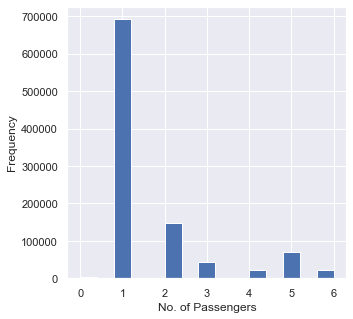

In [14]:
plt.figure(figsize=(5,5))
plt.hist(train_df['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

In [15]:
# index = np.arange(len(train_df['passenger_count']))
# plt.bar(index, train_df['fare_amount'])
# plt.xlabel('Genre', fontsize=5)
# plt.ylabel('No of Movies', fontsize=5)
# plt.xticks(index, train_df['passenger_count'], fontsize=5, rotation=30)
# plt.title('Market Share for Each Genre 1995-2017')
# plt.show()

In [16]:
# plt.figure(figsize=(10,5))
# plt.scatter(x=train_df['passenger_count'], y=train_df['fare_amount'], s=1.5)
# plt.xlabel('No. of Passengers')
# plt.ylabel('Fare')

In [17]:
train_df.shape

(999920, 8)

In [18]:
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [19]:
train_df['pickup_datetime']=dd.to_datetime(train_df['pickup_datetime'], infer_datetime_format=True)

In [20]:
train_df.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

Feauture engineering

=> Split pickup_datetime into day,month,year


=> Calulate haversine distance in miles using the pickup/dropoff latitude/longitude values

In [21]:
#Time of day
train_df['Hour'] = train_df['pickup_datetime'].dt.hour
train_df['Minute'] = train_df['pickup_datetime'].dt.minute
train_df['Second'] = train_df['pickup_datetime'].dt.second

#Days of week 0-Monday 1-Tuesday 2-Wednesday 3-Thursday 4-Friday 5-Saturday 6-Sunday
train_df['day_of_week'] = train_df['pickup_datetime'].dt.weekday

#Date format mm dd year
train_df['Month'] = train_df['pickup_datetime'].dt.month
train_df['Date'] = train_df['pickup_datetime'].dt.day
train_df['Year'] = train_df['pickup_datetime'].dt.year

In [22]:
train_df['Hour'].describe()

count    999920.000000
mean         13.510192
std           6.512968
min           0.000000
25%           9.000000
50%          14.000000
75%          19.000000
max          23.000000
Name: Hour, dtype: float64

In [23]:
train_df['day_of_week'].describe()

count    999920.000000
mean          3.040088
std           1.949767
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: day_of_week, dtype: float64

In [24]:
def over_night (row):
    if (row['Hour'] >= 20) or (row['Hour'] <= 6):
        return 1
    else:
        return 0


def rush_hour (row):
    if ((row['Hour'] >=16) and (row['Hour'] <= 20)) and (row['day_of_week'] <= 4):
        return 1
    else:
        return 0
    
train_df['rush_hour'] = train_df.apply(lambda x: rush_hour(x), axis=1)
train_df['over_night'] = train_df.apply(lambda x: over_night(x), axis=1) 

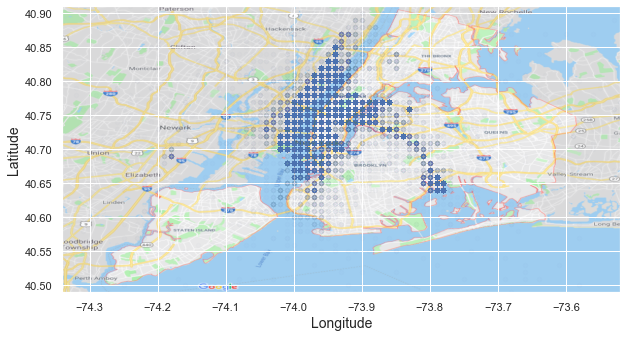

In [25]:
import matplotlib.image as mpimg
newyork_imp=mpimg.imread('newyork.png')
train_set1 = train_df.round({'pickup_longitude':2 , 'pickup_latitude':2})

ax = train_set1.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", figsize=(10,7),
                        alpha=0.01, color ='b')
plt.imshow(newyork_imp, extent=[-74.34, -73.52, 40.49, 40.91], alpha=0.9)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

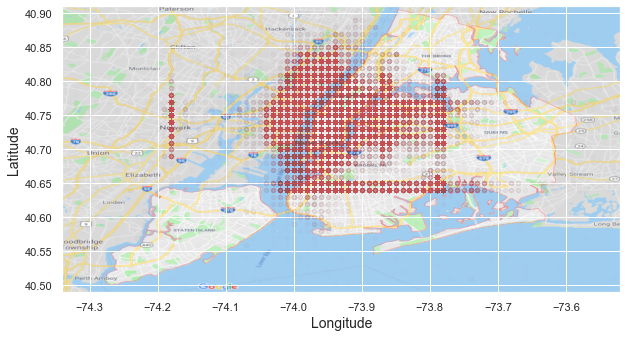

In [26]:
newyork_imp=mpimg.imread('newyork.png')
train_set1 = train_df.round({'dropoff_longitude':2 , 'pickup_latitude':2})

ax = train_set1.plot(kind="scatter", x="dropoff_longitude", y="pickup_latitude", figsize=(10,7),
                        alpha=0.01, color ='r' )
plt.imshow(newyork_imp, extent=[-74.34, -73.52, 40.49, 40.91], alpha=0.9)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

In [31]:
def distance(data):
    R = 3956        # Radius of earth in miles
    
    pickup_data = data[['pickup_longitude','pickup_latitude']]
    dropoff_data = data[['dropoff_longitude','dropoff_latitude']]
    
    phi1 = np.radians(pickup_data['pickup_latitude'])
    phi2 = np.radians(dropoff_data['dropoff_latitude'])
    
    delta_phi = np.radians(dropoff_data['dropoff_latitude'] - pickup_data['pickup_latitude'])
    delta_lambda = np.radians(dropoff_data['dropoff_longitude'] - pickup_data['pickup_longitude'])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin((delta_phi)/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = R * c
    
    return d

# add new column to dataframe with distance in miles
train_df['distance_in_miles'] = distance(train_df)

In [32]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)


In [33]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 962353
New size: 962353


In [34]:
def distanceNyc(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 3.0) & (train_df.abs_diff_latitude < 3.0)]
train_df = train_df[(train_df.pickup_longitude >= -74.3) & (train_df.pickup_longitude <= -72.9)]  # nyc coordinates
train_df = train_df[(train_df.dropoff_longitude >= -74.3) & (train_df.dropoff_longitude <= -72.9)]
train_df = train_df[(train_df.pickup_latitude >= 40.5) & (train_df.pickup_latitude <= 41.8)]
train_df = train_df[(train_df.dropoff_latitude >= 40.5) & (train_df.dropoff_latitude <= 41.8)]
train_df = train_df[(train_df.distance_in_miles<=100.0) & (train_df.distance_in_miles>0.05)]
nyc = (-74.0063889, 40.7141667)
train_df['distance_to_center'] = distanceNyc(nyc[1], nyc[0],train_df.dropoff_latitude, train_df.dropoff_longitude)
train_df = train_df[train_df.distance_to_center<15.0]
print('New size: %d' % len(train_df))

Old size: 962353
New size: 962353


In [35]:
(train_df.head())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Minute,...,day_of_week,Month,Date,Year,rush_hour,over_night,distance_in_miles,abs_diff_longitude,abs_diff_latitude,distance_to_center
540979,58:33.0,7.5,2009-06-15 17:26:21+00:00,-73.980954,40.753287,-73.981101,40.737323,1,17,26,...,0,6,15,2009,1,0,1.102265,0.000147,0.015964,2.076805
166737,07:25.0,4.1,2010-01-05 16:52:16+00:00,-73.965430,40.766099,-73.956791,40.766693,1,16,52,...,1,1,5,2010,1,0,0.453620,0.008639,0.000594,4.462378
279192,39:00.0,4.1,2011-08-18 00:35:00+00:00,-73.976318,40.753612,-73.983662,40.747990,1,0,35,...,3,8,18,2011,0,1,0.546109,0.007344,0.005622,2.622465
483018,28:01.0,6.5,2012-04-21 04:30:42+00:00,-73.976521,40.765655,-73.971394,40.749473,1,4,30,...,5,4,21,2012,0,1,1.149016,0.005127,0.016182,3.050881
163282,34:00.0,4.5,2010-03-09 07:51:00+00:00,-73.987427,40.724745,-73.979385,40.730022,5,7,51,...,1,3,9,2010,0,0,0.556611,0.008042,0.005277,1.788756


In [36]:
train_df.to_csv('FinalData.csv')

In [37]:
columns = ['fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'Hour', 'Minute', 'Second',
       'day_of_week', 'Month', 'Date', 'Year', 'rush_hour', 'over_night',
       'distance_in_miles', 'abs_diff_longitude', 'abs_diff_latitude',
       'distance_to_center']
learning_data = pd.read_csv('FinalData.csv',usecols = columns).sample(n=1000000,replace=True)

In [38]:
learning_data.shape

(1000000, 20)

In [39]:
learning_data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Hour',
       'Minute', 'Second', 'day_of_week', 'Month', 'Date', 'Year', 'rush_hour',
       'over_night', 'distance_in_miles', 'abs_diff_longitude',
       'abs_diff_latitude', 'distance_to_center'],
      dtype='object')

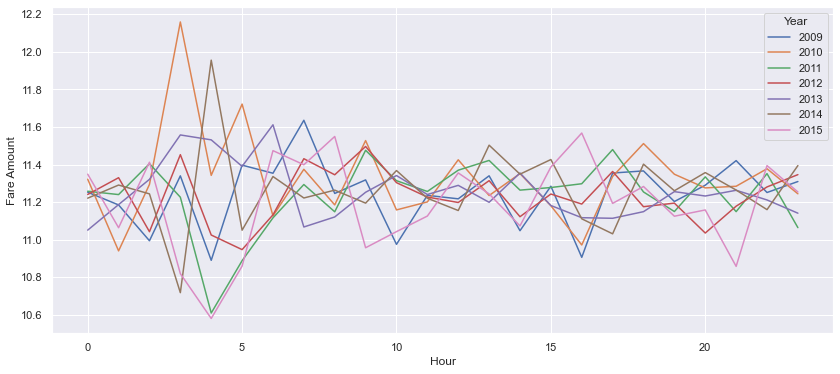

In [40]:
learning_data.pivot_table('fare_amount', index='Hour', columns='Year').plot(figsize=(14,6))
plt.ylabel('Fare Amount');

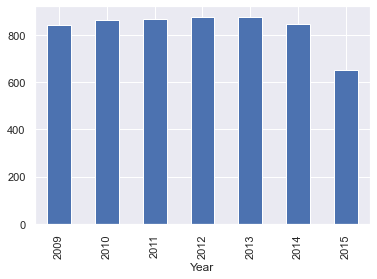

In [41]:
learning_data.groupby('Year')['fare_amount'].nunique().plot(kind='bar')
plt.show()

Model Selection

In [42]:
y = learning_data['fare_amount']

In [43]:
X = learning_data.drop(['fare_amount','pickup_datetime','abs_diff_longitude','abs_diff_latitude'],axis = 1)

In [44]:
X.shape

(1000000, 16)

In [45]:
X.head()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Minute,Second,day_of_week,Month,Date,Year,rush_hour,over_night,distance_in_miles,distance_to_center
494091,-73.951560,40.713887,-73.967444,40.707343,2,21,44,32,0,2,11,2013,0,1,0.946178,2.093464
564145,-74.010421,40.729828,-73.986296,40.762470,1,13,30,18,5,6,1,2013,0,0,2.583030,3.499282
237558,-73.980778,40.761701,-73.991959,40.751067,1,15,53,0,1,12,29,2009,0,0,0.938646,2.659145
591532,-73.995996,40.727080,-73.983349,40.730461,2,9,16,16,6,12,20,2009,0,0,0.701697,1.650170
657646,-73.776706,40.645225,-73.976295,40.794211,1,20,44,39,4,5,24,2013,1,1,14.659642,5.750448


In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size = .3)

In [47]:
X_train.shape[0]

700000

In [48]:
y_train.shape[0]

700000

In [49]:
X_val.shape[0]

300000

In [50]:
y_val.shape[0]

300000

In [51]:
from sklearn.svm import SVR
def svr_linear(X,y):
    start_time = time.time()
    svr_lin = SVR(kernel='linear', C=7, gamma='auto')
    y_lin = svr_lin.fit(X, y)
    
    return svr_lin, start_time

def svr_RBF(X,y):
    start_time = time.time()
    svr_rbf = SVR(kernel='rbf', C=15, gamma=0.1, epsilon=.1)
    y_rbf = svr_rbf.fit(X, y)
    
    return svr_rbf, start_time

In [52]:
# t1 = pool.apply_async(svr_RBF, (X,y)) 
# t2 = pool.apply_async(svr_linear, (X,y)) 

# svr_rbf, rbf_start_time = t1.get()
# svr_lin, lin_start_time = t2.get()

In [53]:
# SVR_RBF_predict = svr_rbf.predict(X_val)
# SVR_Lin_predict = svr_lin.predict(X_val)

# SVR_RBF_mse = mean_squared_error(y_val, SVR_RBF_predict)
# SVR_Lin_mse = mean_squared_error(y_val, SVR_Lin_predict)

# SVR_RBF_rmse = np.sqrt(SVR_RBF_mse)
# SVR_Lin_rmse = np.sqrt(SVR_Lin_mse)

# print("RMSE of Linear support vector regressor = " , SVR_Lin_rmse)
# print("Run time of Linear support vector regressor = " , time.time() - lin_start_time , "seconds")
# print("\nRMSE of RBF support vector regressor = " , SVR_RBF_rmse)
# print("Run time of RBF support vector regressor = " , time.time() - rbf_start_time , "seconds")

LINEAR REGRESSION

In [54]:
start_time = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
#print("-------LINEAR REGRESSION------")
print("Training score: ",lr.score(X_train,y_train))
print("Validation score: ",lr.score(X_val,y_val))

y_pred = lr.predict(X_val)
print("Predicted output: ",y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_val))
print("Mean Squared Error: ",rmse)
print("Time taken = %s seconds" % (time.time() - start_time))

Training score:  0.7495098558900701
Validation score:  0.7541676681073286
Predicted output:  [14.45873861 15.45832348  7.54844181 ... 17.28951393  6.87907776
 30.70707009]
Mean Squared Error:  4.594521120301024
Time taken = 0.6028509140014648 seconds


DECISION TREE REGRESSOR

In [55]:
start_time = time.time()
modelTreeReg = tree.DecisionTreeRegressor()
modelTreeReg.fit(X_train, y_train)

predictTreeReg = modelTreeReg.predict(X_val)
print("Predicted output: ",predictTreeReg)
tree_mse = mean_squared_error(y_val, predictTreeReg)
treeRMSE = np.sqrt(tree_mse)
print("Mean Squared error: ",treeRMSE)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [15.5 18.   5.7 ... 34.5  6.9 21.3]
Mean Squared error:  3.5122536173137227
Time taken = 14.935019493103027 seconds


In [56]:
start_time = time.time()
modelTreeReg1 = tree.DecisionTreeRegressor(max_depth=2)
modelTreeReg1.fit(X_train, y_train)

predictTreeReg1 = modelTreeReg1.predict(X_val)
print("Predicted output: ",predictTreeReg1)
tree_mse1 = mean_squared_error(y_val, predictTreeReg1)
treeRMSE1 = np.sqrt(tree_mse1)
print("Mean Squared error: ",treeRMSE1)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [13.88954577 13.88954577  7.22340156 ... 13.88954577  7.22340156
 28.13839289]
Mean Squared error:  4.674909702498771
Time taken = 1.2202486991882324 seconds


In [57]:
start_time = time.time()
modelTreeReg2 = tree.DecisionTreeRegressor(max_depth=5)
modelTreeReg2.fit(X_train, y_train)

predictTreeReg2 = modelTreeReg2.predict(X_val)
print("Predicted output: ",predictTreeReg2)
tree_mse2 = mean_squared_error(y_val, predictTreeReg2)
treeRMSE2 = np.sqrt(tree_mse2)
print("Mean Squared error: ",treeRMSE2)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [15.71432147 15.71432147  6.4022655  ... 15.71432147  6.4022655
 26.42543647]
Mean Squared error:  3.8505228954322153
Time taken = 3.297027826309204 seconds


In [58]:
start_time = time.time()
modelTreeReg3 = tree.DecisionTreeRegressor(max_depth=7,random_state=0)
modelTreeReg3.fit(X_train, y_train)

predictTreeReg3 = modelTreeReg3.predict(X_val)
print("Predicted output: ",predictTreeReg3)
tree_mse3 = mean_squared_error(y_val, predictTreeReg3)
treeRMSE3 = np.sqrt(tree_mse3)
print("Mean Squared error: ",treeRMSE3)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [16.36752236 14.36429803  6.27834105 ... 16.36752236  6.72088606
 28.30659437]
Mean Squared error:  3.723578554213856
Time taken = 4.5313990116119385 seconds


RANDOM FOREST REGRESSOR

In [59]:
start_time = time.time()
randomForest = RandomForestRegressor(n_estimators=10,random_state=0)
randomForest.fit(X_train, y_train)

#print("---------RANDOM FOREST----------")
print("Training score: ",randomForest.score(X_train,y_train))
print("Validation score: ",randomForest.score(X_val,y_val))

randomForestPredict = randomForest.predict(X_val)
print("Predicted output: ",randomForestPredict)
randomForest_RMSE = np.sqrt(mean_squared_error(y_val, randomForestPredict))
print("Mean Squared error: ",randomForest_RMSE)
print("Time taken = %s seconds" % (time.time() - start_time))

Training score:  0.9826032815060416
Validation score:  0.9121216817815968
Predicted output:  [14.75  15.6    6.35  ... 27.45   7.56  21.919]
Mean Squared error:  2.747018728566176
Time taken = 133.7543020248413 seconds


IMPROVED RANDOM FOREST REGRESSOR

In [60]:
start_time = time.time()
model = RandomForestRegressor(n_estimators=25, max_features=6, max_depth=25, min_samples_split=3,
                              min_samples_leaf=2, random_state=0)
randomForestImproved = model.fit(X_train,y_train)

#print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict = randomForestImproved.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict)
randomForestImproved_mse = mean_squared_error(y_val, randomForestImprovedPredict)
randomForestImprovedMSE = np.sqrt(randomForestImproved_mse)
print("Mean Squared error: ",randomForestImprovedMSE)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [14.81283043 15.99961116  6.06294244 ... 24.72476273  7.32956761
 22.30480072]
Mean Squared error:  2.8482128264832496
Time taken = 109.30013084411621 seconds


In [61]:
start_time = time.time()
model1 = RandomForestRegressor(n_estimators=15, max_features=3, max_depth=20, min_samples_split=2,
                              min_samples_leaf=2, random_state=0)
randomForestImproved1 = model1.fit(X_train,y_train)

print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict1 = randomForestImproved1.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict1)
randomForestImproved_mse1 = mean_squared_error(y_val, randomForestImprovedPredict1)
randomForestImprovedMSE1 = np.sqrt(randomForestImproved_mse1)
print("Mean Squared error: ",randomForestImprovedMSE1)
print("Time taken = %s seconds" % (time.time() - start_time))

---------IMPROVED RANDOM FOREST------------
Predicted output:  [15.12028771 14.53754974  6.16061934 ... 21.51313045  7.01684046
 23.55051097]
Mean Squared error:  3.191627034450603
Time taken = 26.862080812454224 seconds


In [62]:
start_time = time.time()
model2 = RandomForestRegressor(n_estimators=25, max_features=8, max_depth=25, min_samples_split=3,
                              min_samples_leaf=3, random_state=30)
randomForestImproved2 = model2.fit(X_train,y_train)

#print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict2 = randomForestImproved2.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict2)
randomForestImproved_mse2 = mean_squared_error(y_val, randomForestImprovedPredict2)
randomForestImprovedMSE2 = np.sqrt(randomForestImproved_mse2)
print("Mean Squared error: ",randomForestImprovedMSE2)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [16.90841508 15.81014253  6.35684146 ... 23.25099127  7.34366908
 22.47261823]
Mean Squared error:  2.9055162436147275
Time taken = 143.07697343826294 seconds


In [63]:
start_time = time.time()
model3 = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=20, min_samples_split=3,
                              min_samples_leaf=2, random_state=0)
randomForestImproved3 = model3.fit(X_train,y_train)

#print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict3 = randomForestImproved3.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict3)
randomForestImproved_mse3 = mean_squared_error(y_val, randomForestImprovedPredict3)
randomForestImprovedMSE3 = np.sqrt(randomForestImproved_mse3)
print("Mean Squared error: ",randomForestImprovedMSE3)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [15.55025947 14.1828947   6.24839115 ... 22.60015642  7.12083973
 23.00820198]
Mean Squared error:  3.05774944726579
Time taken = 65.67776870727539 seconds


Text(0.5, 1.0, 'Feature Importance for Random Forest')

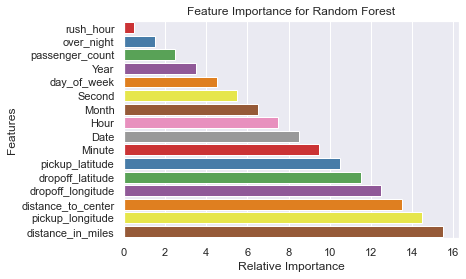

In [64]:
feature_importance = randomForestImproved.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sns.barplot(x = pos,y = X_train.columns[sorted_idx], palette = 'Set1')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Random Forest')

In [70]:
regression = pd.DataFrame({"regression": ['Linear Regression','Decision Tree','Random Forest', 'Tuned Random Forest'],
                           "rmse": [rmse,treeRMSE3,randomForest_RMSE,randomForestImprovedMSE2]},
                            columns = ['regression','rmse'])

In [66]:
regression = regression.sort_values(by='rmse', ascending = False)

In [69]:
regression = pd.DataFrame({"regression": ['Linear Regression','Decision Tree','Random Forest', 'Tuned Random Forest'],
                           "rmse": [rmse,treeRMSE3,randomForest_RMSE,randomForestImprovedMSE2]},
                            columns = ['regression','rmse'])

Text(0.5, 1.0, 'Comparing the different types of Regressions used')

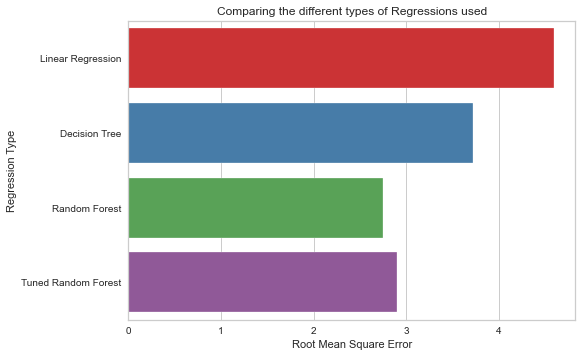

In [71]:
sns.barplot(x = regression['rmse'],y = regression['regression'], palette = 'Set1')
plt.ylabel('Regression Type')
plt.xlabel("Root Mean Square Error")
plt.title('Comparing the different types of Regressions used')

In [72]:
from yellowbrick.regressor import ResidualsPlot

C:\Users\kashi\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


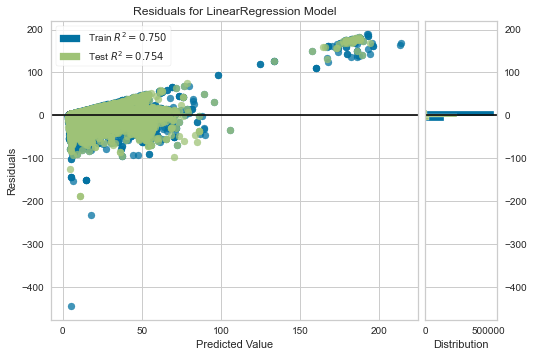

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [73]:
visualizerDT = ResidualsPlot(lr)

visualizerDT.fit(X_train, y_train)  # Fit the training data to the model
visualizerDT.score(X_val, y_val)  # Evaluate the model on the test data
visualizerDT.poof()                 # Draw/show/poof the data

C:\Users\kashi\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


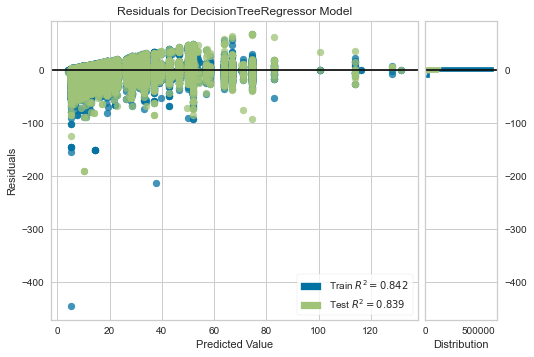

<AxesSubplot:title={'center':'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [74]:
visualizerDT = ResidualsPlot(modelTreeReg3)

visualizerDT.fit(X_train, y_train)  # Fit the training data to the model
visualizerDT.score(X_val, y_val)  # Evaluate the model on the test data
visualizerDT.poof()                 # Draw/show/poof the data

C:\Users\kashi\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


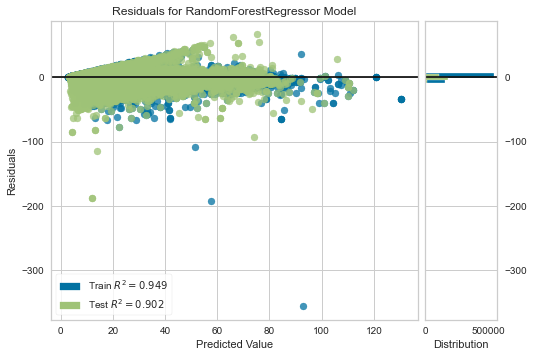

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [75]:
visualizerDT = ResidualsPlot(model2)

visualizerDT.fit(X_train, y_train)  # Fit the training data to the model
visualizerDT.score(X_val, y_val)  # Evaluate the model on the test data
visualizerDT.poof()            # Draw/show/poof the data